In [1]:
import cebra
import cebra.datasets
import cebra.models
import cebra.solver

import numpy as np
import matplotlib.pyplot as plt
import torch

/Users/steffen.schneider/code/CEBRA-dev/cebra/datasets/__init__.py:102: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


In [2]:
import cebra.solver

cebra.solver.get_options()

['r2_linear',
 'multi-session',
 'multi-session-aux',
 'multiobjective-solver',
 'single-session',
 'single-session-aux',
 'single-session-hybrid',
 'single-session-full',
 'regularized-solver']

In [3]:
import sys
sys.path.append("..")
import pickle

import cebra.attribution
from cebra.data import DatasetxCEBRA, ContrastiveMultiObjectiveLoader
from cebra.solver import MultiObjectiveConfig

/Users/steffen.schneider/.pyenv/versions/3.10.13/envs/cebra-regcl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the pickle file
with open('synthetic_data.pkl', 'rb') as file:
    synthetic_data = pickle.load(file)

In [5]:
neurons = synthetic_data['neurons']
latents = synthetic_data['latents']
n_latents = latents.shape[1]
Z1 = synthetic_data['Z1']
Z2 = synthetic_data['Z2']
gt_attribution_map = synthetic_data['gt_attribution_map']
data = DatasetxCEBRA(neurons, Z1=Z1, Z2=Z2)

In [6]:
print(f"Observed data: {data.neural.shape}")
print(f"Latents: {latents.shape}")
print(f"Z1: {Z1.shape}")
print(f"Z2: {Z2.shape}")

Observed data: torch.Size([1000, 50])
Latents: torch.Size([1000, 6])
Z1: torch.Size([1000, 3])
Z2: torch.Size([1000, 3])


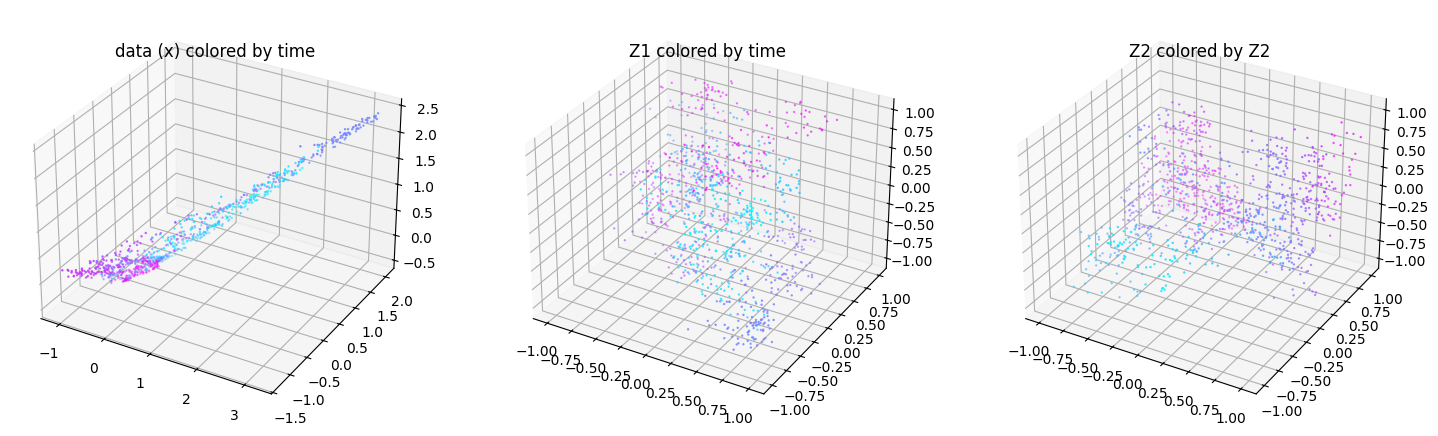

In [7]:
# plot per behavior
idx0, idx1, idx2 = 0, 1, 2
min_, max_ = 0, 10_000#len(data.neural)

fig = plt.figure(figsize=(18, 10))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(data.neural[:, idx0][min_:max_],
                       data.neural[:, idx1][min_:max_],
                       data.neural[:, idx2][min_:max_],
                       c=torch.arange(len(data.neural))[min_:max_], s=0.5, cmap="cool")
ax1.set_title('data (x) colored by time', y=1.0, pad=-10)

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(Z1[:, idx0][min_:max_],
                       Z1[:, idx1][min_:max_],
                       Z1[:, idx2][min_:max_],
                       c=torch.arange(len(data.neural))[min_:max_], s=0.5, cmap="cool")
ax2.set_title('Z1 colored by time', y=1.0, pad=-10)

# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(Z2[:, idx0][min_:max_],
                       Z2[:, idx1][min_:max_],
                       Z2[:, idx2][min_:max_],
                       c=Z2[:, 1][min_:max_], s=0.5, cmap="cool")
ax3.set_title('Z2 colored by Z2', y=1.0, pad=-10)

plt.show()


In [11]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


TOTAL_STEPS = 2_000

print(f"Using {device}")

loader = ContrastiveMultiObjectiveLoader(dataset=data,
                                                num_steps=TOTAL_STEPS,
                                                batch_size=512).to(device)
config = MultiObjectiveConfig(loader)

config.set_slice(0, 6)
config.set_loss("FixedEuclideanInfoNCE", temperature=1.)
config.set_distribution("time", time_offset=1)
config.push()

config.set_slice(3, 6)
config.set_loss("FixedEuclideanInfoNCE", temperature=1.)
config.set_distribution("time_delta", time_delta=1, label_name="Z2")
config.push()

config.finalize()

criterion = config.criterion
feature_ranges = config.feature_ranges


neural_model = cebra.models.init(
    name="offset1-model-mse-clip-5-5",
    num_neurons=data.neural.shape[1],
    num_units=256,
    num_output=n_latents,
).to(device)

data.configure_for(neural_model)

opt = torch.optim.Adam(
    list(neural_model.parameters()) + list(criterion.parameters()),
    lr=3e-4,
    weight_decay=0,
) 

#NOTE: We always initialize the regularizer because we want to compute
# the regularization term independent of whether we use a regularized
# loss or not. We treat it as another metric.
regularizer = cebra.models.jacobian_regularizer.JacobianReg()

solver = cebra.solver.init(
    name="multiobjective-solver",
    model=neural_model,
    feature_ranges=feature_ranges,
    regularizer = regularizer,
    renormalize=False,
    use_sam=False,
    criterion=criterion,
    optimizer=opt,
    tqdm_on=True,
).to(device)


Using cpu
Adding configuration for slice: (0, 6)
Adding configuration for slice: (3, 6)
Adding distribution of slice: (0, 6)
Adding distribution of slice: (3, 6)
Creating MultiCriterion
Computing renormalize ranges...
New ranges: [slice(0, 3, None), slice(3, 6, None)]


In [12]:
from cebra.solver.schedulers import LinearRampUp

weight_scheduler = LinearRampUp(
    n_splits=2,
    step_to_switch_on_reg=2500,
    step_to_switch_off_reg=15_000,
    start_weight=0.,
    end_weight=0.01, 
    stay_constant_after_switch_off = True
)

solver.fit(loader=loader,
           valid_loader=None,
           log_frequency=None,
           scheduler_regularizer = weight_scheduler,
           scheduler_loss = None,
)

sum_loss_train: 3.068: 100%|██████████| 2000/2000 [00:28<00:00, 69.24it/s]


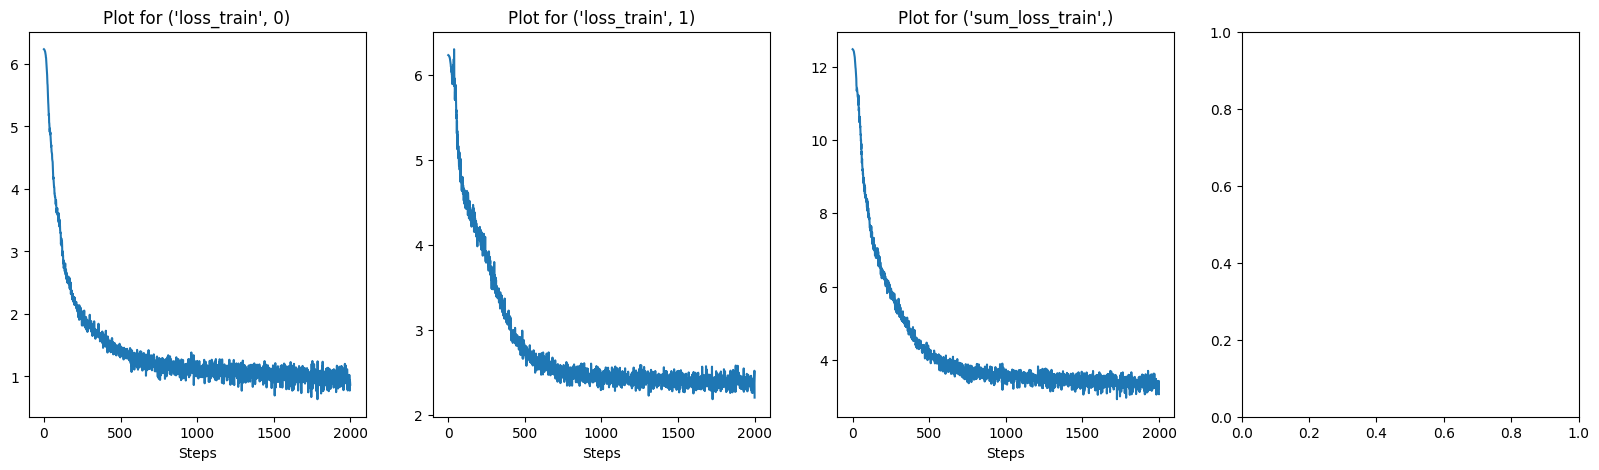

In [13]:
import matplotlib.pyplot as plt

# Plot every key in solver.log
keys = list(solver.log.keys())
for i in range(0, len(keys), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for j, key in enumerate(keys[i:i+4]):
        axs[j].plot(solver.log[key])
        axs[j].set_title(f"Plot for {key}")
        axs[j].set_xlabel("Steps")
        # axs[j].set_ylabel("Value")
    plt.show()


In [14]:
solver.model.split_outputs = False
embedding = solver.model(data.neural.to(device)).detach().cpu()

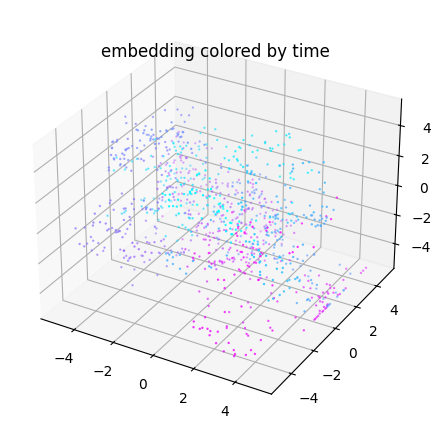

In [15]:
# plot per behavior
idx0, idx1, idx2 = 0, 1, 2
min_, max_ = 0, 10_000

fig = plt.figure(figsize=(18, 10))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(embedding[:, idx0][min_:max_],
                       embedding[:, idx1][min_:max_],
                       embedding[:, idx2][min_:max_],
                       c=torch.arange(len(data.neural))[min_:max_], s=0.5, cmap="cool")
ax1.set_title('embedding colored by time', y=1.0, pad=-10)

# Sec
plt.show()

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Create and fit the linear regression model
model = LinearRegression()
R2 = model.fit(latents.numpy(), embedding.numpy()).score(latents.numpy(), embedding.numpy())
print(f"R2 between observed data and latents is: {R2: .2f}")

R2 between observed data and latents is:  0.97


# Compute attribution map

In [17]:
attribution_split = 'train'
model = solver.model.to(device)
model.split_outputs = False

data.neural.requires_grad_(True)
method = cebra.attribution.init(
    name="jacobian-based",
    model=model,
    input_data=data.neural,
    output_dimension=model.num_output
    )

result = method.compute_attribution_map()

Computing inverse for jf with method lsq
Computing inverse for jf with method svd
Computing inverse for jf-convabs with method lsq
Computing inverse for jf-convabs with method svd


In [18]:
jf = abs(result['jf']).mean(0)
jfinv = abs(result['jf-inv-lsq']).mean(0)
jfconvabsinv = abs(result['jf-convabs-inv-svd']).mean(0)

AUC with jf is:  0.80


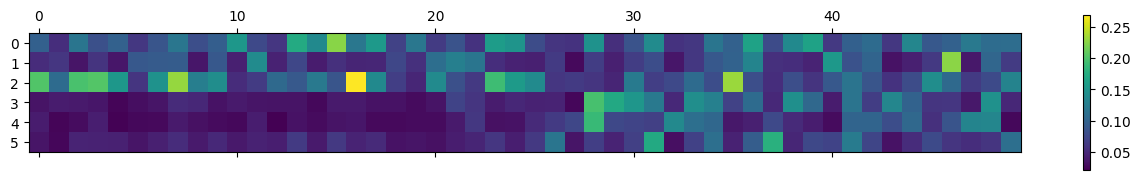

In [20]:
auc_jf = method.compute_attribution_score(jf, gt_attribution_map)
print(f"AUC with jf is: {auc_jf: .2f}")

plt.matshow(jfinv)
plt.colorbar()
plt.show()

AUC with jf_inv is:  0.92


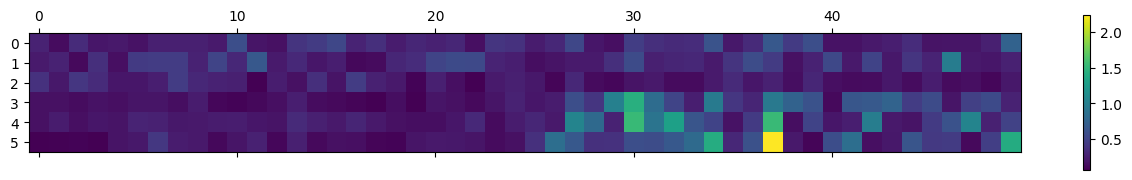

In [21]:
auc_jfinv = method.compute_attribution_score(jfinv, gt_attribution_map)
print(f"AUC with jf_inv is: {auc_jfinv: .2f}")

plt.matshow(jf)
plt.colorbar()
plt.show()

# Other plots

In [22]:
solver.model.split_outputs = True
embedding_split = solver.model(data.neural.to(device))
Z1_hat = embedding_split[0].detach().cpu()
Z2_hat = embedding_split[1].detach().cpu()

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression

R2_dict = {}
for name, variable in {'Z1':Z1, 'Z2':Z2}.items():

    # Create and fit the linear regression model
    model = LinearRegression()
    R2_first_part = model.fit(variable.numpy(), embedding[:, :3].numpy()).score(variable.numpy(), embedding[:, :3].numpy())
    R2_second_part = model.fit(variable.numpy(), embedding[:, 3:].numpy()).score(variable.numpy(), embedding[:, 3:].numpy())
    R2_dict[name] = [R2_first_part, R2_second_part]

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert R2_dict to a DataFrame for easier plotting
R2_df = pd.DataFrame(R2_dict, index=['First Part', 'Second Part'])

display((R2_df*100).round(2).astype(str) + "%")

,Z1,Z2
First Part,93.09%,16.06%
Second Part,15.33%,98.51%
